In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [2]:
# Load data
filepath = '/content/drive/MyDrive/ML Learning/names.txt'
words = open(filepath, 'r').read().splitlines()

In [3]:
# Peek at data
print(words[:10])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
32033


In [4]:
# Creating a mapping from letters to numbers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # Creating the reverse mapping
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [5]:
# ----------> THE BIGRAM COUNTING MODEL <---------- #

In [6]:
# Creating a matrix to show how often each letter follows any other letter
N = torch.zeros((27, 27), dtype=torch.int32)

# Inputing the counts into the tensor
for w in words:
  chs = ['.'] + list(w) + ['.'] # Adding . to start and end of words
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

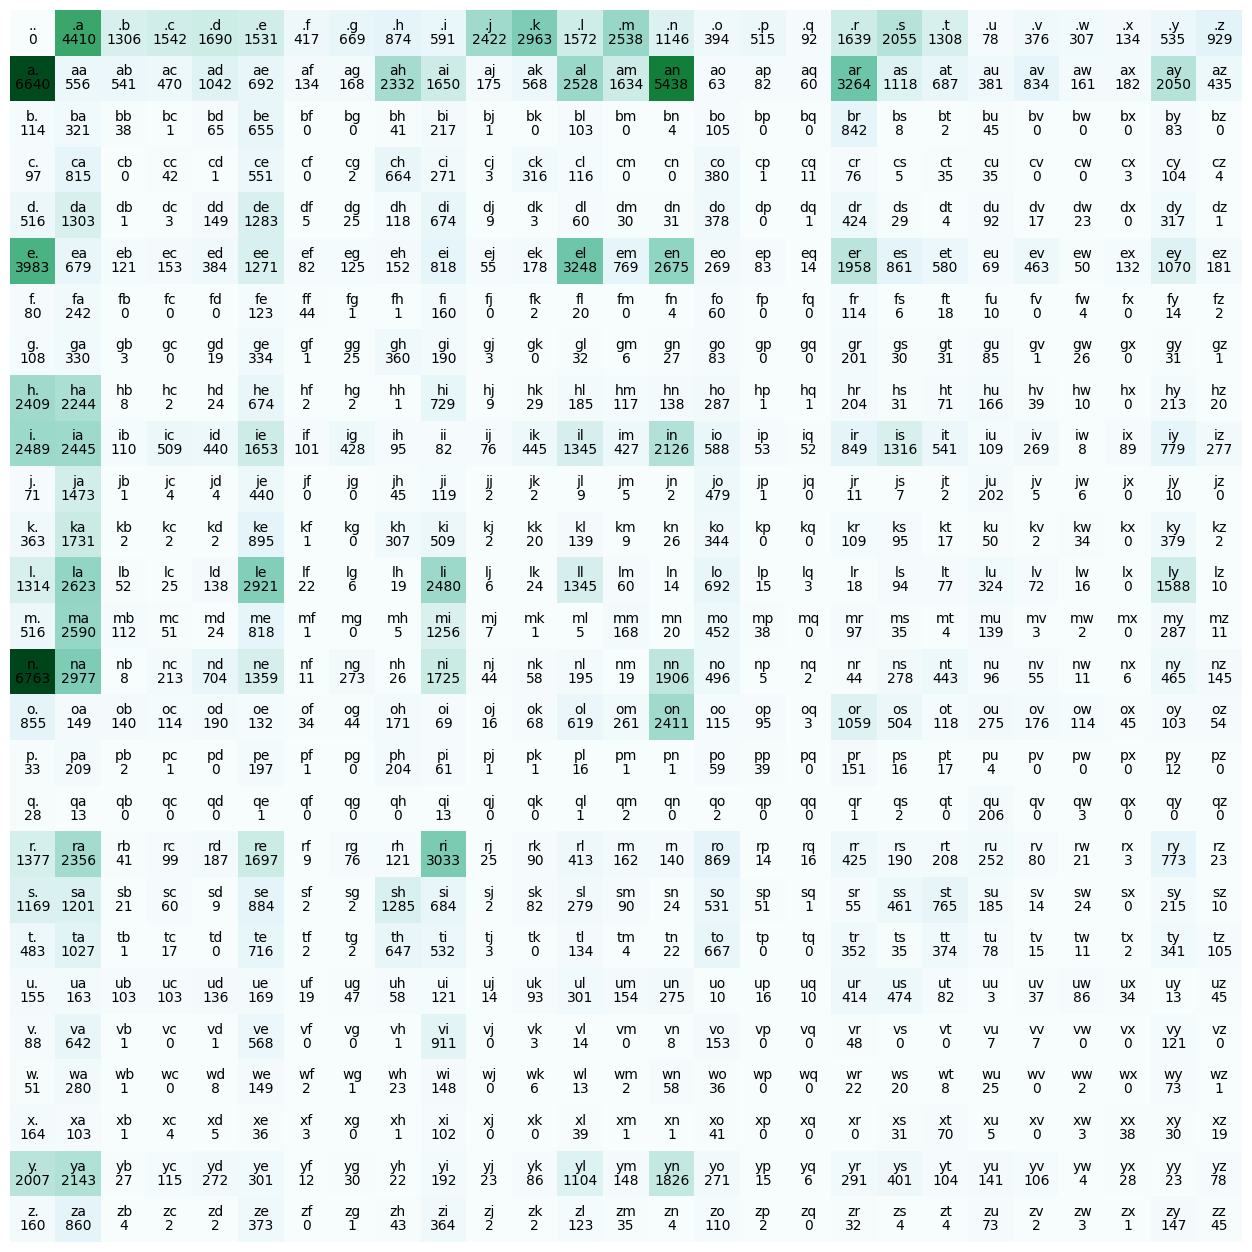

In [7]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='BuGn')
for i in range(N.shape[0]):
  for j in range(N.shape[1]):
    plt.text(j, i, f'{N[i,j]}', ha='center', va='top')
    plt.text(j, i, itos[i]+itos[j], ha='center', va='bottom')
plt.axis('off')

In [8]:
# Walkthrough of Multinomial.

# Generator to get consistent results
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g) # Generate a random tensor with 3 elements
print(p)

# Convert the array to a probability distribution.
p = p/p.sum()
print(p)

 # Multinomial: give probabilities returns a dataset aligned with those probabilities.
 # In this case the probabilities are according to the tensor p (We should have 60% 0s, 30% 1s, and 10% 2s).
 # 'You give me probabilities and I will give you integers sampled according to the probability distribution'.
torch.multinomial(p, num_samples=20, replacement=True, generator=g)

tensor([0.7081, 0.3542, 0.1054])
tensor([0.6064, 0.3033, 0.0903])


tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [9]:
# Demonstraiting model smoothing and pytorch broadcasting.

# Adding one for model smoothing (ensuring no 0s in the prob matrix).
# The higher the number the flatter the distribution. Think Low Pass filter.
P = (N+1).float()

# Pytorch broadcasting is the ability to perform operations with 2 tensors of different shapes.
# Broadcasting allows the automatic expansion of a tensor size to allow operations (both tensors need to be the exact same shape).
# Two tensors are “broadcastable” if the following rules hold:
# Each tensor has at least one dimension.
# When iterating over the dimension sizes, starting at the trailing dimension (right aligned),
# the dimension sizes must either be equal, one of them is 1, or one of them does not exist.
P = P/P.sum(1, keepdim=True)

In [10]:
# Generating names
for i in range(20):
  out = []
  ix = 0
  while True:
    p = P[ix] # Select the ix row

    # Pick a letter out of the row with the letter pick probability aligning with counts.
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

    out.append(itos[ix]) # decode and add to the current word
    if ix == 0: # Stop if an end token is selected
      break

  print(''.join(out))

ze.
sahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.
dgossmitan.
il.
le.
pann.
that.
janreli.
isa.
dyn.


In [11]:
# Looking at the negative log likelihood (NLL) as a loss funciton
from math import log

log_likelihood = 0
n = 0
for w in words[:3]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2] # getting the probability of the combination of letters
    logprob = torch.log(prob) # Probability is usually too small so the log is used
    log_likelihood += logprob # sum the logs to get total proability
    n += 1
    print(f'{ch1}{ch2}: {logprob:.4f}')

print(f'{log_likelihood}')
nll = -log_likelihood # Negative log liklihood is used as we want the loss function to decrease as the model improves.
print(f'{nll/n=}') # Average NLL

.e: -3.0410
em: -3.2793
mm: -3.6753
ma: -0.9454
a.: -1.6305
.o: -4.3965
ol: -2.5526
li: -1.7293
iv: -4.1845
vi: -1.0476
ia: -1.9807
a.: -1.6305
.a: -1.9835
av: -3.7041
va: -1.3971
a.: -1.6305
-38.80856704711914
nll/n=tensor(2.4255)


In [12]:
# -----------> The Neural Net <-------------- #

In [13]:
# Moving to Neural Networks

# Creating a map from letters to numbers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

# Creating the training set (x, y)
xs, ys = [], []
for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of elements: ', num)

# Randomly initialise 27 neurons with each neuron recieving 27 inputs*weights
g = torch.Generator().manual_seed(2147483647)
w = torch.randn((27,27), generator=g, requires_grad=True)

number of elements:  5


In [14]:
# Gradient descent
for k in range (100):

  # Forward Pass
  xenc = F.one_hot(xs, num_classes=27).float() # OHE the inputs
  logits = xenc @ w # inputs multiplied by weights to get
  counts = logits.exp() # Softmax part 1
  probs = counts / counts.sum(1, keepdims=True) # Softmax part 2
  # Negative Log Likelihood, ie the loss function with an included regularisation term.
  loss = -probs[torch.arange(5), ys].log().mean() + 0.01*(w**2).mean()
  print(loss.item())

  # Backward Pass
  w.grad = None # set the gradients to 0 for the weights
  loss.backward()

  # Update
  w.data += -0.1 * w.grad

3.7693049907684326
3.7492127418518066
3.7291626930236816
3.7091541290283203
3.6891887187957764
3.6692662239074707
3.6493873596191406
3.629552125930786
3.6097614765167236
3.5900158882141113
3.5703155994415283
3.5506606101989746
3.5310521125793457
3.5114905834198
3.491975784301758
3.4725089073181152
3.453089952468872
3.4337196350097656
3.414397716522217
3.3951258659362793
3.375903367996216
3.356731414794922
3.3376102447509766
3.318540096282959
3.2995219230651855
3.2805557250976562
3.26164174079895
3.242781162261963
3.2239737510681152
3.2052199840545654
3.18652081489563
3.1678762435913086
3.1492867469787598
3.1307530403137207
3.1122748851776123
3.09385347366333
3.075488567352295
3.0571811199188232
3.0389316082000732
3.0207395553588867
3.0026066303253174
2.984531879425049
2.9665169715881348
2.948561191558838
2.930665969848633
2.9128310680389404
2.895056962966919
2.8773443698883057
2.8596930503845215
2.842103958129883
2.8245773315429688
2.8071131706237793
2.789712429046631
2.772374868392944

In [19]:
# Sampling from the Neural Net
for i in range(5):

  out = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float() # OHE the first row
    logits = xenc @ w
    counts = logits.sum(1, keepdims=True)

    ix = torch.multinomial(p, num_samples=1, replacement=True).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

e.
e.
da.
.
vi.
